In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import leastsq
import matplotlib.pyplot as plt


In [2]:
# 目标函数
def real_func(x):
    return np.sin(2*np.pi*x)

#多项式函数拟合 p为多项式的各个参数组成的数组，作为poly1d函数的参数返回一个多项式函数
def fit_func(p,x):
    f = np.poly1d(p)
    return f(x)
# 残差
def res_func(p,x,y):
    res = fit_func(p,x) - y
    return res

In [3]:
# 计算均方误差
def meansquare(y1, y0):
    return np.sum((y1-y0)*(y1-y0))

### 产生测试数据

In [4]:
x_train = np.linspace(0,1,20)
y_train_real = real_func(x_train)
y_train_noise = [np.random.normal(0,0.1) + yi for yi in y_train_real] #在y上加入正态分布的噪声干扰

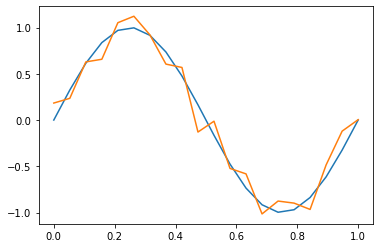

In [5]:
plt.plot(x_train,y_train_real)
plt.plot(x_train,y_train_noise)

In [6]:
x_plt= np.linspace(0,1,1000)


In [7]:
def fitting(x,y,M=0): #M为拟合曲线的阶数
    #随机初始化参数：
    p_init = np.random.rand(M+1)
    #最小二乘法
    p_lsp = leastsq(res_func, p_init, args=(x, y)) #返回p参数，loss_function为均方函数
    y_o = fit_func(p_lsp[0],x_train)
    mse = meansquare(y_o,y)
    print("fitting paras: ",p_lsp)
    print("fitting meansquare: ", mse)
        
    #可视化
    plt.plot(x_plt,fit_func(p_lsp[0], x_plt),label="fitting curve")
    plt.plot(x_train,y_train_noise,'ro',label="noised curve")
    plt.plot(x_train,y_train_real,label="real curve")
    plt.legend()
    return p_lsp

fitting paras:  (array([-1.5616822 ,  0.79933325]), 1)
fitting meansquare:  4.73351990094851


(array([-1.5616822 ,  0.79933325]), 1)

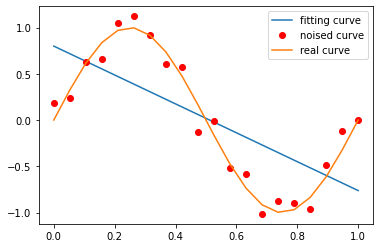

In [8]:
# M = 1 一阶拟合
fitting(x_train, y_train_noise, 1)

fitting paras:  (array([ 21.15888414, -31.39511397,  10.46807077,  -0.04323692]), 1)
fitting meansquare:  0.5183145073744821


(array([ 21.15888414, -31.39511397,  10.46807077,  -0.04323692]), 1)

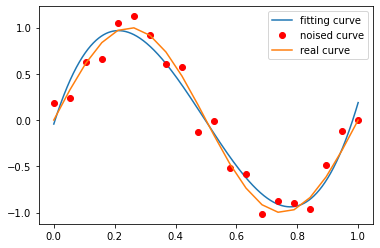

In [9]:
# M = 2 3阶拟合
fitting(x_train, y_train_noise, 3)

fitting paras:  (array([-7.18722326e+01,  1.81048349e+02, -1.39523017e+02,  2.75742655e+01,
        2.68302886e+00,  1.31433848e-01]), 1)
fitting meansquare:  0.3025293677602093


(array([-7.18722326e+01,  1.81048349e+02, -1.39523017e+02,  2.75742655e+01,
         2.68302886e+00,  1.31433848e-01]),
 1)

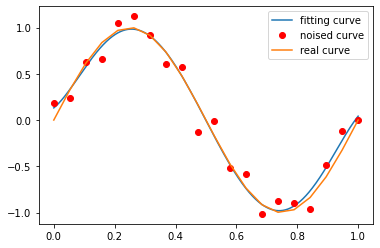

In [10]:
# M = 5 5阶拟合
fitting(x_train, y_train_noise, 5)

fitting paras:  (array([-5.56530946e+03,  2.80408305e+04, -6.15446281e+04,  7.66577730e+04,
       -5.88655176e+04,  2.81325630e+04, -7.91426455e+03,  1.10364590e+03,
       -4.76284940e+01,  2.36181462e+00,  1.77182706e-01]), 1)
fitting meansquare:  0.2344457615204472


(array([-5.56530946e+03,  2.80408305e+04, -6.15446281e+04,  7.66577730e+04,
        -5.88655176e+04,  2.81325630e+04, -7.91426455e+03,  1.10364590e+03,
        -4.76284940e+01,  2.36181462e+00,  1.77182706e-01]),
 1)

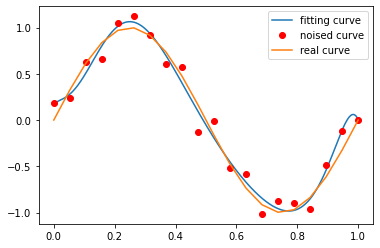

In [11]:
# M = 10 10阶拟合
fitting(x_train, y_train_noise, 10)

#### 过拟合现象
当M逐渐变大后会出现过拟合现象，这是由于参数过多导致的，过多的参数会引入过多的不确定度，确定这些参数所需要的信息熵也会变多，当实际获得的信息熵不足时即信道容量小，但数据所需的信息量大，该模型最终得到的结果一定会出错

虽然拟合的mse较好，但是模型的好坏不仅仅是由测试的loss_result来判断，还需要train_data甚至更大的数据来测试，过拟合解决办法有多种：
1. 增加训练的数据集
2. 信道匹配（调整信源使其匹配信道，可以通过信源压缩（但信息熵依然要大于R(D),否则必然最终得到的结果必然失真，其中D为信道允许的失真度）（减少x,y之间的不确定度，空间变换可以做到这一点），或者调整信源（过滤掉无关信息熵），使得此时信道容量最大，）降低模型的复杂度
3. 这里使用正则化，原理是：参数过多会引入更多的负反馈，使得模型参数趋于稳定
4. 永远选择拟合效果第二的模型去搭建自己的模型，最终结果可能比第一的模型拟合得更好

$ Q(x) = \sum_{i=1}^n(h(x_i)-y_i)^2+\lambda||w||^2$ 正则化后的损失函数 二阶范数 引入负反馈 $\lambda||w||^2$

In [19]:
r = 0.0001
def res_func_regularize(p,x,y):
    res = fit_func(p,x)-y
    res = np.append(res, np.sqrt(0.5*r*p*p))
    return res

In [20]:
def fitting_regularize(x,y,M=0): #M为拟合曲线的阶数
    #随机初始化参数：
    p_init = np.random.rand(M+1)
    #最小二乘法
    p_lsp = leastsq(res_func_regularize, p_init, args=(x, y)) #返回p参数，loss_function为均方函数
    y_o = fit_func(p_lsp[0],x_train)
    mse = meansquare(y_o,y)
    print("fitting paras: ",p_lsp)
    print("fitting meansquare: ", mse)
        
    #可视化
    plt.plot(x_plt,fit_func(p_lsp[0], x_plt),label="fitting curve")
    plt.plot(x_train,y_train_noise,'ro',label="noised curve")
    plt.plot(x_train,y_train_real,label="real curve")
    plt.legend()
    return p_lsp

fitting paras:  (array([ -3.27494584,  -2.70003979,  -1.21463077,   1.78848917,
         6.00662733,   8.96110214,   5.0838804 ,  -9.50590099,
       -12.23027436,   7.05183214,   0.05679604]), 1)
fitting meansquare:  0.3492128434132855


(array([ -3.27494584,  -2.70003979,  -1.21463077,   1.78848917,
          6.00662733,   8.96110214,   5.0838804 ,  -9.50590099,
        -12.23027436,   7.05183214,   0.05679604]),
 1)

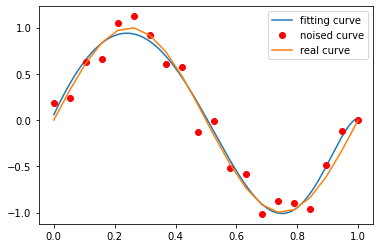

In [21]:
# M = 10 10阶拟合
fitting_regularize(x_train, y_train_noise, 10)

fitting paras:  (array([ -1.37586304,   0.33133222,   0.88716497,   0.44906969,
        -0.66087352,  -1.90833924,  -2.55841298,  -1.76789333,
         1.07668834,   5.58709704,   9.05642618,   5.52744705,
        -9.27148861, -12.51152286,   7.10181179,   0.0557514 ]), 1)
fitting meansquare:  0.34866354781542636


(array([ -1.37586304,   0.33133222,   0.88716497,   0.44906969,
         -0.66087352,  -1.90833924,  -2.55841298,  -1.76789333,
          1.07668834,   5.58709704,   9.05642618,   5.52744705,
         -9.27148861, -12.51152286,   7.10181179,   0.0557514 ]),
 1)

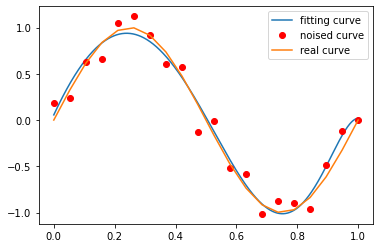

In [23]:
# M = 15 10阶拟合
fitting_regularize(x_train, y_train_noise, 15)

可以看出来在正则化后，模型的抗过拟合的效果变好了很多，带来的问题是模型收敛慢，虽然不容易过拟合，但也不容易得到最优模型